<a href="https://colab.research.google.com/github/yorkjong/vistock/blob/feature%2Fibd/notebooks/ibd_rs_line.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install and Setup

#### Install Required Packages

In [1]:
%pip install "git+https://github.com/yorkjong/vistock.git@feature/ibd"

  Cloning https://github.com/yorkjong/vistock.git (to revision feature/ibd) to /tmp/pip-req-build-o6vgl3mk
  Running command git clone --filter=blob:none --quiet https://github.com/yorkjong/vistock.git /tmp/pip-req-build-o6vgl3mk
  Running command git checkout -b feature/ibd --track origin/feature/ibd
  Switched to a new branch 'feature/ibd'
  Branch 'feature/ibd' set up to track remote branch 'feature/ibd' from 'origin'.
  Resolved https://github.com/yorkjong/vistock.git to commit 793450c662aef1966e1f7fae89230b8ddece203d
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.3 MB/s eta 0:00:00
  Created wheel for vistock: filename=vistock-0.4.0-py3-none-any.whl size=55207 sha256=51f5d861f17542c04ecb20a7c99fe02c05d24c58da58aa01b2883fe67319da96
  Stored in directory: /tmp/pip-ephem-wheel-cache-w54yjw3v/wheels/07/97/7f/a72c7fbc975be0326ac45fec1ca0c872e2d6e2bbea96caf706
Successfully built vistock


### Stock Chart Featuring IBD’s RS Line and its Moving Averages

[*********************100%%**********************]  2 of 2 completed


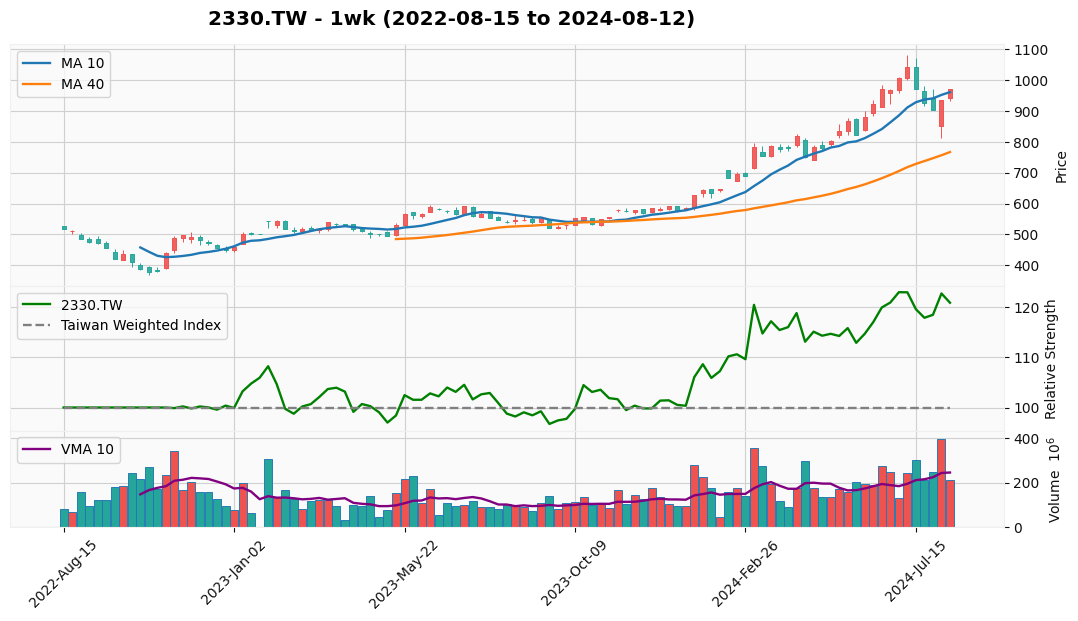

In [ ]:
# @title Plot IBD stock chart using mplfinance {"run":"auto"}
symbol = "台積電" #@param ["TSLA", "NVDA", "MSFT", "AAPL", "GOOG", "MSTR", "TQQQ", "SOXL", "TSM", "台積電", "2330", "元太", "BTC-USD", "ETH-USD"] {allow-input: true}
period = "2y" # @param ["1y","2y","5y"]
interval = "1wk" # @param ["1d","1wk"]
hides_nontrading = True # @param {"type":"boolean"}
legend_loc = "best" # @param ["best","upper right","upper left","lower left","lower right","right","center left","center right","lower center","upper center","center"]
style = "tradingview" # @param ["yahoo","charles","tradingview","binance","binancedark","mike","nightclouds","checkers","ibd","sas","starsandstripes","kenan","blueskies","brasil"]

from vistock.mpl import ibd_rs

ibd_rs.plot(symbol, period, interval, hides_nontrading=hides_nontrading,
            legend_loc=legend_loc, style=style)

In [ ]:
# @title Plot IBD stock chart using Plotly {"run":"auto"}
symbol = "TSLA" #@param ["TSLA", "NVDA", "MSFT", "AAPL", "GOOG", "MSTR", "TQQQ", "SOXL", "TSM", "台積電", "2330", "元太", "BTC-USD", "ETH-USD"] {allow-input: true}
period = "2y" # @param ["1y","2y","5y"]
interval = "1wk" # @param ["1d","1wk"]
hides_nontrading = True # @param {"type":"boolean"}

from vistock.plotly import ibd_rs

ibd_rs.plot(symbol, period, interval, hides_nontrading=hides_nontrading)

[*********************100%%**********************]  2 of 2 completed


### Comparing Indices with RS Lines

GridBox(children=(Checkbox(value=True, description='^GSPC', layout=Layout(margin='2px', width='auto')), Checkb…

Button(description='Generate Plot', style=ButtonStyle())

[*********************100%%**********************]  8 of 8 completed


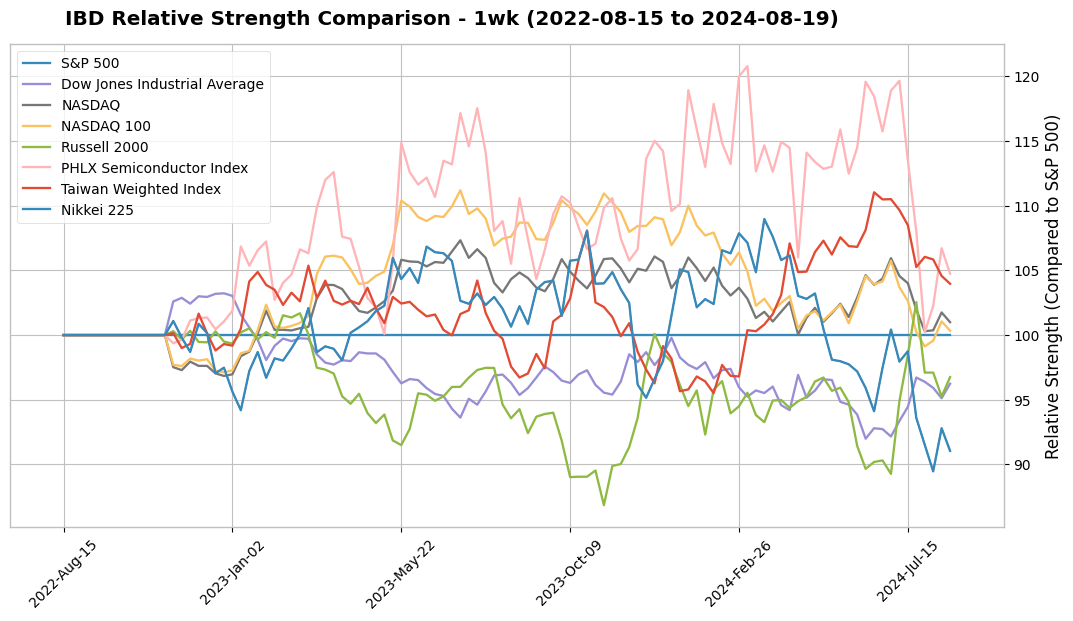

In [9]:
# @title Plot RS Lines using mplfinance {"run":"auto"}
period = "2y" # @param ["1y","2y","5y"]
interval = "1wk" # @param ["1d","1wk"]
hides_nontrading = True # @param {"type":"boolean"}
legend_loc = "best" # @param ["best","upper right","upper left","lower left","lower right","right","center left","center right","lower center","upper center","center"]
style = "checkers" # @param ["yahoo","charles","tradingview","binance","binancedark","mike","nightclouds","checkers","ibd","sas","starsandstripes","kenan","blueskies","brasil"]


import ipywidgets as widgets

def major_indices():
    return ['^GSPC', '^DJI', '^IXIC', '^NDX', '^RUT', '^SOX',
            '^TWII', '^N225', '^HSI',
            '^STOXX50E', '^FTSE', '^GDAXI', '^FCHI', '^GSPTSE']

available_tickers = major_indices()

# Create checkboxes for stock selection with the first 8 items pre-checked
checkboxes = [
    widgets.Checkbox(
        value=(i < 8),  # Set first 8 items as checked
        description=ticker,
        layout=widgets.Layout(width='auto', margin='2px')
    )
    for i, ticker in enumerate(available_tickers)
]

n_cols = 5  # Number of columns in the grid

checkbox_grid = widgets.GridBox(checkboxes, layout=widgets.Layout(
    width='auto',
    grid_template_columns=f'repeat({n_cols}, 1fr)',
    grid_gap='10px'
))

# Button to confirm selection and plot
button = widgets.Button(description="Generate Plot")

# Display UI elements
display(checkbox_grid, button)


def get_selected_stocks():
    selected_stocks = [checkbox.description
                       for checkbox in checkboxes if checkbox.value]
    return selected_stocks

def validate_selection(selected_stocks):
    if len(selected_stocks) > 8:
        print("You can only select up to 8 stocks. Please deselect some items.")
        return selected_stocks[:8]  # Limit to 8 items
    return selected_stocks


from vistock.mpl import ibd_rs_cmp

# Define the button click event
def on_button_click(b):
    selected_stocks = get_selected_stocks()
    symbols = validate_selection(selected_stocks)
    if not symbols:
        print("No stocks selected. Please select at least one stock.")
        return
    ibd_rs_cmp.plot(symbols, period, interval,
                    hides_nontrading=hides_nontrading,
                    legend_loc=legend_loc, style=style)


button.on_click(on_button_click)



In [4]:
# @title Plot RS Lines using Plotly {"run":"auto"}
period = "2y" # @param ["1y","2y","5y"]
interval = "1wk" # @param ["1d","1wk"]
hides_nontrading = True # @param {"type":"boolean"}

from vistock.plotly import ibd_rs_cmp

symbols=["^GSPC", "^SOX", "^TWII", "^NDX", "^GDAXI", "^N225", "^HSI"]
ibd_rs_cmp.plot(symbols, period, interval, hides_nontrading=hides_nontrading)

[*********************100%%**********************]  7 of 7 completed
